## Library Import

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from psycopg2 import Error
import os
from dotenv import load_dotenv
import datetime as dt

## SQL Connection Set UP

In [2]:
# Read in ENV credentials 

load_dotenv()

username = os.getenv('USERNAME')
password = os.getenv('PASSWORD')

In [3]:
# Connection to db 
USER = username
PSWD = password
HOST = "pg.analytics.northwestern.edu"
PORT = "5432"
DB_NAME = "everything2023"

# Connect to postgress database
try:
    # Connect to an existing database
    connection = psycopg2.connect(user = USER,
                                  password = PSWD,
                                  host = HOST,
                                  port = PORT,
                                  database = DB_NAME)
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
    
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

You are connected to -  ('PostgreSQL 10.12 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39), 64-bit',) 



## FEATURE SELECTION

#### get Y label for return rate per store per day (ReturnRate is our y_label)

#### feature 1: number of transactions per store per day

#### feature 2: number of discount sale per day

#### feature 3: amount of money sale per day

#### Ideas of features
#### STATE /location  -- i ma not sure how to use (visualization)
#### SKU properties (price of SKU)  
#### time/year
#### keep brainstorming.....

In [4]:
# Read trnsact table
sql_cmd = """
WITH DailyReturnRates AS (
    SELECT 
        "SALEDATE", 
        "STORE", 
        SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END) / 
        (SUM(CASE WHEN "STYPE" = 'P' THEN 1.0 ELSE 0.0 END) + SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END)) AS "ReturnRate",
        COUNT(*) AS "NumTrans",
        SUM(CASE WHEN "SPRICE" < "ORGPRICE" THEN 1 ELSE 0 END) AS "DiscountSalesCount",
        SUM("AMT") AS "AmtTrans",
        AVG("SPRICE") AS "AvgPrice"
    FROM 
        group_14.trnsact
    GROUP BY 
        "SALEDATE", 
        "STORE"
)
SELECT 
    "SALEDATE", 
    "STORE", 
    "ReturnRate",
    LAG("ReturnRate", 1) OVER (PARTITION BY "STORE" ORDER BY "SALEDATE") AS "PreviousDayReturnRate",
    LAG("ReturnRate", 7) OVER (PARTITION BY "STORE" ORDER BY "SALEDATE") AS "PreviousWeekReturnRate",
    LAG("ReturnRate", 30) OVER (PARTITION BY "STORE" ORDER BY "SALEDATE") AS "PreviousMonthReturnRate",
    "NumTrans",
    "DiscountSalesCount",
    "AmtTrans",
    "AvgPrice", 
    LAG(drr."NumTrans", 1) OVER (PARTITION BY drr."STORE" ORDER BY drr."SALEDATE") AS "PreviousDayTrans",
    LAG(drr."AmtTrans", 1) OVER (PARTITION BY drr."STORE" ORDER BY drr."SALEDATE") AS "PreviousDayAmtTrans",
    (SELECT SUM(subdrr."NumTrans")
     FROM DailyReturnRates subdrr
     WHERE subdrr."STORE" = drr."STORE" 
     AND subdrr."SALEDATE" BETWEEN drr."SALEDATE" - INTERVAL '30 days' AND drr."SALEDATE") AS "Last30DaysTrans",
    (SELECT SUM(subdrr."AmtTrans")
     FROM DailyReturnRates subdrr
     WHERE subdrr."STORE" = drr."STORE" 
     AND subdrr."SALEDATE" BETWEEN drr."SALEDATE" - INTERVAL '30 days' AND drr."SALEDATE") AS "Last30DaysAmtTrans"
FROM 
    DailyReturnRates drr
ORDER BY 
    "SALEDATE", 
    "STORE";
"""
return_df = pd.read_sql(sql_cmd, connection);

/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_59259/2419310726.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return_df = pd.read_sql(sql_cmd, connection);


In [5]:
return_df.to_csv("return_df.csv", index = False)

## ADD location feature

In [9]:
sql_cmd = """
SELECT "STATE", "STORE"
FROM 
  group_14.strinfo

"""
strinfo = pd.read_sql(sql_cmd, connection);
strinfo.head()

/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_42175/3992140737.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  strinfo = pd.read_sql(sql_cmd, connection);


,STATE,STORE
0,FL,2
1,MO,3
2,AR,4
3,TX,7
4,AZ,9


In [14]:
new_return_df = return_df.merge(strinfo, how = "left", on = "STORE")

In [15]:
new_return_df.to_csv("return_df_with_store.csv", index = False)

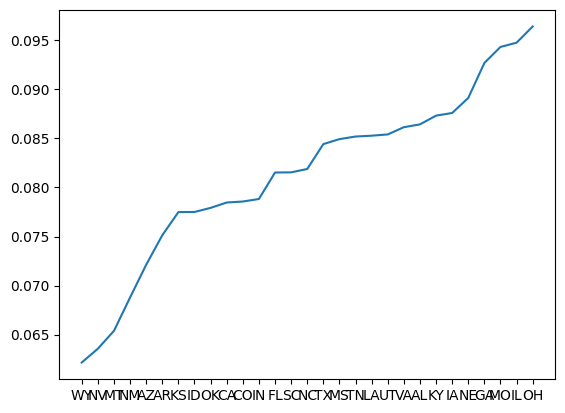

In [16]:
plt.plot(new_return_df.groupby(["STATE"])["ReturnRate"].mean().sort_values())

The top 10 states with the most returns 

In [16]:
# Extract different time features 
return_rate_df['Month'] = pd.to_datetime(return_rate_df['SALEDATE']).dt.month
return_rate_df['Quarter'] = pd.to_datetime(return_rate_df['SALEDATE']).dt.quarter
return_rate_df['Day'] = pd.to_datetime(return_rate_df['SALEDATE']).dt.dayofweek
return_rate_df

,SALEDATE,STORE,ReturnRate,NumTrans,DiscountSalesCount,AmtTrans,Month,Quarter,Day
0,2004-08-01,102,0.046968,1171,533,34507.81,8,3,6
1,2004-08-01,103,0.059271,658,349,16873.44,8,3,6
2,2004-08-01,107,0.062332,1492,716,34605.01,8,3,6
3,2004-08-01,202,0.054707,786,420,17108.43,8,3,6
4,2004-08-01,203,0.100752,665,423,16585.97,8,3,6
...,...,...,...,...,...,...,...,...,...
125915,2005-08-27,9704,0.064167,1200,911,20079.25,8,3,5
125916,2005-08-27,9709,0.051787,1371,952,24007.62,8,3,5
125917,2005-08-27,9804,0.056711,1587,1173,29260.54,8,3,5
125918,2005-08-27,9806,0.002625,1143,516,33762.85,8,3,5


In [17]:
# JOIN skstinfo and skuinfo to get cost of sku 
sql_cmd = """
SELECT sku."SKU", sks."Cost"
FROM group_14.skstinfo sks
JOIN group_14.skuinfo sku on sku."SKU" = sks."SKU"
"""
skstinfo = pd.read_sql(sql_cmd, connection);
skstinfo.head()

/Users/hujiayu/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,SKU,Cost
0,1918,15.00
1,3986,26.85
2,3986,26.85
3,3986,26.85
4,3986,26.85


In [18]:
# Use SKU and Store info to calcualte return rate
sql_cmd = """
SELECT "SKU", 
SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END) / 
	(SUM(CASE WHEN "STYPE" = 'P' THEN 1.0 ELSE 0.0 END) + SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END)) as "ReturnRate"
FROM group_14.trnsact
GROUP BY "SKU"
ORDER BY "SKU"
"""
sku_return_rate = pd.read_sql(sql_cmd, connection);

/Users/hujiayu/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [19]:
sku_return_rate.head(20)

,SKU,ReturnRate
0,3,0.200000
1,4,0.103448
2,5,0.090909
3,8,0.142857
4,20,0.000000
5,23,0.166667
6,24,0.034483
7,50,1.000000
8,55,0.000000
9,65,0.000000


## Data Visualization

In [20]:
## how return rate for store 102 working in times series
def plot_return_for_store(store_num):
    # Filter the DataFrame for store 102
    store_data = return_rate_df[return_rate_df['STORE'] == store_num]
    
    # Ensure SaleDate is a datetime type for proper plotting
    store_data['SALEDATE'] = pd.to_datetime(store_data['SALEDATE'])
    
    # Plotting
    plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
    plt.plot(store_data['SALEDATE'], store_data['ReturnRate'], marker='o')
    
    plt.title(f'Return Rate Over Time for Store {store_num}')
    plt.xlabel('Sale Date')
    plt.ylabel('Return Rate')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjusts plot parameters to give the plot more room
    
    # Display the plot
    plt.show()

/var/folders/8d/9mc5tfw918v62xbjw8qkwmbm0000gn/T/ipykernel_876/3275164606.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_data['SALEDATE'] = pd.to_datetime(store_data['SALEDATE'])


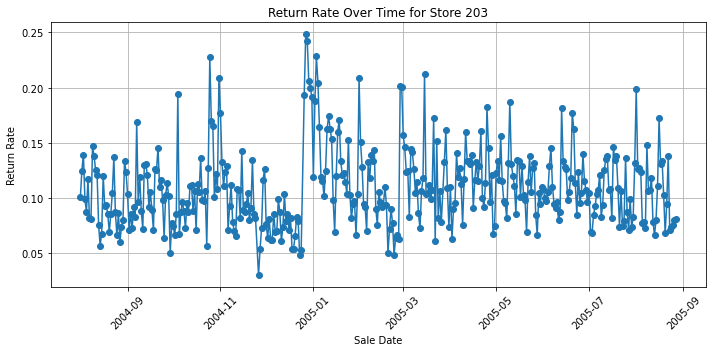

In [21]:
plot_return_for_store(203)

# Linear Regression Model

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Selecting relevant features and the target variable
features = ['NumTrans', 'DiscountSalesCount', 'AmtTrans', 'Month', 'Quarter', 'Day']  # Add other features you want to include
target = 'ReturnRate'

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(return_rate_df[features], return_rate_df[target], test_size=0.2, random_state=42)


In [24]:
model = LinearRegression()

# Train 
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)


In [25]:
# coefficients
print('Coefficients: \n', model.coef_)

# mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# coefficient of determination
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))


Coefficients: 
 [-7.13971204e-05  3.68727116e-05  1.62688511e-06 -1.99424803e-03
  2.78766641e-03 -4.76054895e-03]
Mean squared error: 0.00
Coefficient of determination: 0.23


In [28]:
! pip install statsmodels

In [29]:
import statsmodels.api as sm
 
X_train_sm = sm.add_constant(X_train)

sm_model = sm.OLS(y_train, X_train_sm).fit()

print(sm_model.summary())


                            OLS Regression Results                            
Dep. Variable:             ReturnRate   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     5195.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:13:32   Log-Likelihood:             2.1653e+05
No. Observations:              100736   AIC:                        -4.331e+05
Df Residuals:                  100729   BIC:                        -4.330e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1153      0



\[ \text{ReturnRate} = -7.1397 \times 10^{-5} \times \text{NumTrans} + 3.6873 \times 10^{-5} \times \text{DiscountSalesCount} + 1.6269 \times 10^{-6} \times \text{AmtTrans} - 0.00199 \times \text{Month} + 0.00279 \times \text{Quarter} - 0.00476 \times \text{Day} + \text{Intercept} \]

